In [2]:
import pandas as pd

In [3]:
!pip install pyarrow

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt 

In [ ]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error

In [6]:
pd.__version__

'1.4.2'

In [7]:
df = pd.read_parquet("https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2024-01.parquet")

In [8]:
df

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
0,2,2024-01-01 00:57:55,2024-01-01 01:17:43,1.0,1.72,1.0,N,186,79,2,17.70,1.00,0.5,0.00,0.00,1.0,22.70,2.5,0.0
1,1,2024-01-01 00:03:00,2024-01-01 00:09:36,1.0,1.80,1.0,N,140,236,1,10.00,3.50,0.5,3.75,0.00,1.0,18.75,2.5,0.0
2,1,2024-01-01 00:17:06,2024-01-01 00:35:01,1.0,4.70,1.0,N,236,79,1,23.30,3.50,0.5,3.00,0.00,1.0,31.30,2.5,0.0
3,1,2024-01-01 00:36:38,2024-01-01 00:44:56,1.0,1.40,1.0,N,79,211,1,10.00,3.50,0.5,2.00,0.00,1.0,17.00,2.5,0.0
4,1,2024-01-01 00:46:51,2024-01-01 00:52:57,1.0,0.80,1.0,N,211,148,1,7.90,3.50,0.5,3.20,0.00,1.0,16.10,2.5,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2964619,2,2024-01-31 23:45:59,2024-01-31 23:54:36,NaN,3.18,NaN,None,107,263,0,15.77,0.00,0.5,2.00,0.00,1.0,21.77,NaN,NaN
2964620,1,2024-01-31 23:13:07,2024-01-31 23:27:52,NaN,4.00,NaN,None,114,236,0,18.40,1.00,0.5,2.34,0.00,1.0,25.74,NaN,NaN
2964621,2,2024-01-31 23:19:00,2024-01-31 23:38:00,NaN,3.33,NaN,None,211,25,0,19.97,0.00,0.5,0.00,0.00,1.0,23.97,NaN,NaN
2964622,2,2024-01-31 23:07:23,2024-01-31 23:25:14,NaN,3.06,NaN,None,107,13,0,23.88,0.00,0.5,5.58,0.00,1.0,33.46,NaN,NaN


In [9]:
df.tpep_pickup_datetime= pd.to_datetime(df.tpep_pickup_datetime)
df.tpep_dropoff_datetime = pd.to_datetime(df.tpep_dropoff_datetime)

In [10]:
df["duration"]= df.tpep_dropoff_datetime - df.tpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds()/60 )

/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='duration', ylabel='Density'>

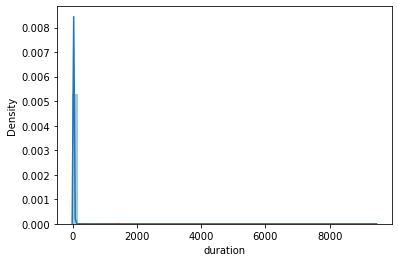

In [11]:
sns.distplot(df.duration)

In [12]:
df.duration.describe()

count    2.964624e+06
mean     1.561295e+01
std      3.485105e+01
min     -1.356667e+01
25%      7.150000e+00
50%      1.163333e+01
75%      1.868333e+01
max      9.455400e+03
Name: duration, dtype: float64

In [48]:
df["duration"].describe(percentiles= [.90, .98, .99])

count    2.929211e+06
mean     1.579804e+01
std      3.502015e+01
min      1.016667e+00
50%      1.176667e+01
90%      2.901667e+01
98%      5.116667e+01
99%      6.060000e+01
max      9.455400e+03
Name: duration, dtype: float64

In [ ]:
df[(df.duration>1) & (df.duration<61)].mean()

In [49]:
df = df[(df.duration>1) & (df.duration<61)]

In [50]:
df

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,duration
0,2,2024-01-01 00:57:55,2024-01-01 01:17:43,1.0,1.72,1.0,N,186,79,2,17.70,1.00,0.5,0.00,0.00,1.0,22.70,2.5,0.0,19.800000
1,1,2024-01-01 00:03:00,2024-01-01 00:09:36,1.0,1.80,1.0,N,140,236,1,10.00,3.50,0.5,3.75,0.00,1.0,18.75,2.5,0.0,6.600000
2,1,2024-01-01 00:17:06,2024-01-01 00:35:01,1.0,4.70,1.0,N,236,79,1,23.30,3.50,0.5,3.00,0.00,1.0,31.30,2.5,0.0,17.916667
3,1,2024-01-01 00:36:38,2024-01-01 00:44:56,1.0,1.40,1.0,N,79,211,1,10.00,3.50,0.5,2.00,0.00,1.0,17.00,2.5,0.0,8.300000
4,1,2024-01-01 00:46:51,2024-01-01 00:52:57,1.0,0.80,1.0,N,211,148,1,7.90,3.50,0.5,3.20,0.00,1.0,16.10,2.5,0.0,6.100000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2964619,2,2024-01-31 23:45:59,2024-01-31 23:54:36,NaN,3.18,NaN,None,107,263,0,15.77,0.00,0.5,2.00,0.00,1.0,21.77,NaN,NaN,8.616667
2964620,1,2024-01-31 23:13:07,2024-01-31 23:27:52,NaN,4.00,NaN,None,114,236,0,18.40,1.00,0.5,2.34,0.00,1.0,25.74,NaN,NaN,14.750000
2964621,2,2024-01-31 23:19:00,2024-01-31 23:38:00,NaN,3.33,NaN,None,211,25,0,19.97,0.00,0.5,0.00,0.00,1.0,23.97,NaN,NaN,19.000000
2964622,2,2024-01-31 23:07:23,2024-01-31 23:25:14,NaN,3.06,NaN,None,107,13,0,23.88,0.00,0.5,5.58,0.00,1.0,33.46,NaN,NaN,17.850000


In [51]:
categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

In [53]:
df[categorical] = df[categorical].astype(str)

/tmp/ipykernel_2634/1767203464.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[categorical] = df[categorical].astype(str)


In [54]:
df[categorical].dtypes

PULocationID    object
DOLocationID    object
dtype: object

In [55]:
df[numerical]

,trip_distance
0,1.72
1,1.80
2,4.70
3,1.40
4,0.80
...,...
2964619,3.18
2964620,4.00
2964621,3.33
2964622,3.06


In [56]:
df[categorical + numerical].iloc[:10].to_dict(orient ='records')

[{'PULocationID': '186', 'DOLocationID': '79', 'trip_distance': 1.72},
 {'PULocationID': '140', 'DOLocationID': '236', 'trip_distance': 1.8},
 {'PULocationID': '236', 'DOLocationID': '79', 'trip_distance': 4.7},
 {'PULocationID': '79', 'DOLocationID': '211', 'trip_distance': 1.4},
 {'PULocationID': '211', 'DOLocationID': '148', 'trip_distance': 0.8},
 {'PULocationID': '148', 'DOLocationID': '141', 'trip_distance': 4.7},
 {'PULocationID': '138', 'DOLocationID': '181', 'trip_distance': 10.82},
 {'PULocationID': '246', 'DOLocationID': '231', 'trip_distance': 3.0},
 {'PULocationID': '161', 'DOLocationID': '261', 'trip_distance': 5.44},
 {'PULocationID': '113', 'DOLocationID': '113', 'trip_distance': 0.04}]

In [57]:
train_dict= df[categorical + numerical].to_dict(orient ='records')

In [58]:
dv = DictVectorizer()
X_train = dv.fit_transform(train_dict)

In [59]:
dv.feature_names_

['DOLocationID=1',
 'DOLocationID=10',
 'DOLocationID=100',
 'DOLocationID=101',
 'DOLocationID=102',
 'DOLocationID=105',
 'DOLocationID=106',
 'DOLocationID=107',
 'DOLocationID=108',
 'DOLocationID=109',
 'DOLocationID=11',
 'DOLocationID=111',
 'DOLocationID=112',
 'DOLocationID=113',
 'DOLocationID=114',
 'DOLocationID=115',
 'DOLocationID=116',
 'DOLocationID=117',
 'DOLocationID=118',
 'DOLocationID=119',
 'DOLocationID=12',
 'DOLocationID=120',
 'DOLocationID=121',
 'DOLocationID=122',
 'DOLocationID=123',
 'DOLocationID=124',
 'DOLocationID=125',
 'DOLocationID=126',
 'DOLocationID=127',
 'DOLocationID=128',
 'DOLocationID=129',
 'DOLocationID=13',
 'DOLocationID=130',
 'DOLocationID=131',
 'DOLocationID=132',
 'DOLocationID=133',
 'DOLocationID=134',
 'DOLocationID=135',
 'DOLocationID=136',
 'DOLocationID=137',
 'DOLocationID=138',
 'DOLocationID=139',
 'DOLocationID=14',
 'DOLocationID=140',
 'DOLocationID=141',
 'DOLocationID=142',
 'DOLocationID=143',
 'DOLocationID=144',

In [60]:
target = 'duration'
Y_train = df[target].values

In [61]:
Y_train

array([19.8       ,  6.6       , 17.91666667, ..., 19.        ,
       17.85      , 15.08333333])

In [62]:
Linear_re = LinearRegression()
Linear_re.fit(X_train, Y_train)

LinearRegression()

In [63]:
pred = Linear_re.predict(X_train)

/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


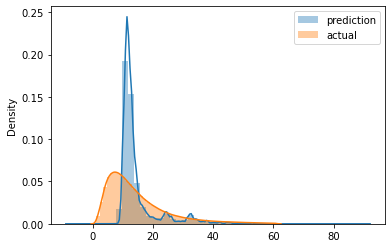

In [64]:
sns.distplot(pred, label ='prediction')
sns.distplot(Y_train, label ='actual')
plt.legend()



In [65]:
mean_squared_error(Y_train, pred, squared=False)

7.987756308346855